In [36]:
#Header Files
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle

%matplotlib inline

In [37]:
#Helper Function
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def findChessBoardCorners(image,nx,ny):
    return cv2.findChessboardCorners(gray, (nx,ny),None)
def drawChessBoardCorners(image,nx,ny,corners,ret):
    return cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
def calibrateCamera(objpoints,imgpoints,shape):
    return cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
def UnDistortImage(image,mtx,dist):
    return cv2.undistort(image,mtx,dist,None,mtx)
def Sobelxy(gray,gradient,sobel_kernel):
    if gradient == 'x':
        return cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        return cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    
    

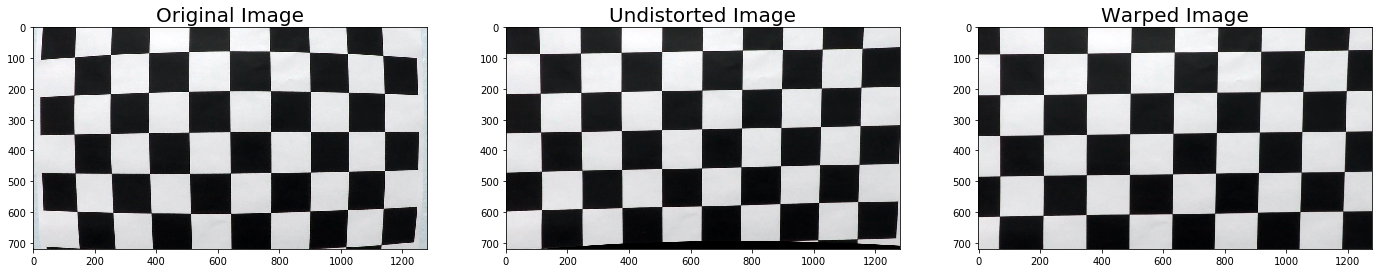

In [196]:
#Camera Calibration
objp = np.zeros((5*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)
nx = 9
ny = 5
fname = './camera_cal/calibration1.jpg'
image = cv2.imread(fname)
gray = grayscale(image)
ret, corners = findChessBoardCorners(gray,nx,ny)
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    #img = drawChessBoardCorners(image, 9,5, corners, ret)
    ret, mtx, dist, rvecs, tvecs = calibrateCamera(objpoints, imgpoints, image.shape[1:])
    undst = UnDistortImage(image,mtx,dist)
    offset = 100
    img_size = (gray.shape[1], gray.shape[0])
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped =cv2.warpPerspective(undst, M,img_size)
    fig, ax = plt.subplots(1,3,figsize=(24, 9))
    ax[0].imshow(image)
    ax[0].set_title('Original Image', fontsize=20)
    ax[1].imshow(undst)
    ax[1].set_title('Undistorted Image', fontsize=20)
    ax[2].imshow(warped)
    ax[2].set_title('Warped Image', fontsize=20)
    


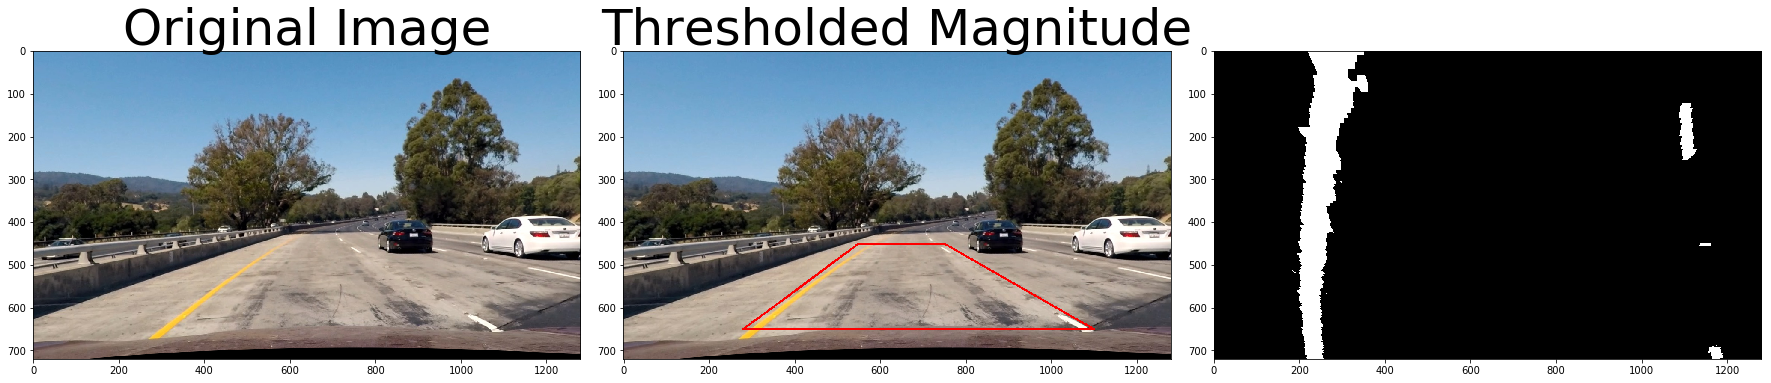

In [197]:
# Read in an image
image = mpimg.imread('./test_images/test1.jpg')
image = UnDistortImage(image,mtx,dist)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
gray = grayscale(image)
S = hls[:,:,2]
mag_binary = mag_thresh(gray,S, sobel_kernel=3, mag_thresh=(90, 255))

offset = 100
img_size = (gray.shape[1], gray.shape[0])
#src = np.float32([[800,450],[1100,650],[500,450],[280,650]])
src = np.float32([[280,650],[1100,650],[750,450],[550,450]])
pts = np.array(src, np.int32)
#dst = np.float32([[896,720],[384,720],[896,0],[384,0]])
pts = pts.reshape((-1,1,2))
copy = image.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)
bottom_left = [200,720]
bottom_right = [1200, 720]
top_left = [100, 1]
top_right = [1200, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
#src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
#dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
#                               [img_size[0]-offset, img_size[1]-offset], 
#                                [offset, img_size[1]-offset]])
M = cv2.getPerspectiveTransform(src, dst)
warped =cv2.warpPerspective(mag_binary, M,img_size)
#histogram = hist(mag_binary)
# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(copy)
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax3.imshow(warped,cmap='gray')

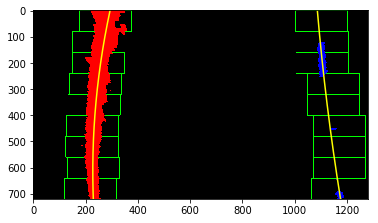

In [198]:
# Load our image
binary_warped = warped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

In [64]:

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit
    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.0601831657289 1976.296730771477


In [148]:
def mag_thresh(gray,S, sobel_kernel=3, mag_thresh=(90, 255)):
    binary_output = np.zeros_like(S)
    binary_output[(S > mag_thresh[0]) & (S <= mag_thresh[1])] = 1
    return binary_output
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)    
    return histogram